In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [14]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
# save and drop the Id column from the data
train_Id = train_df['Id']
test_Id = test_df['Id']
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


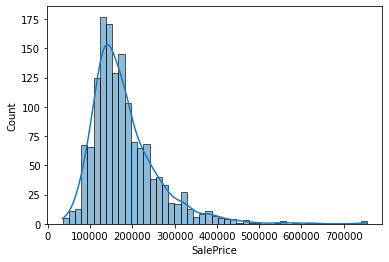

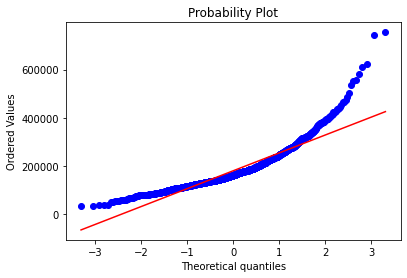

In [16]:
# plot SalePrice distribution
sns.histplot(train_df, x='SalePrice', kde=True)
plt.show()
stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

The target variable SalePrice does not satisfy normality, it is right skewed. If we were looking to fit a linear regression model we might choose to log transform the SalePrice, but with a Random Forest model this will not affect the accuracy. 

<AxesSubplot:>

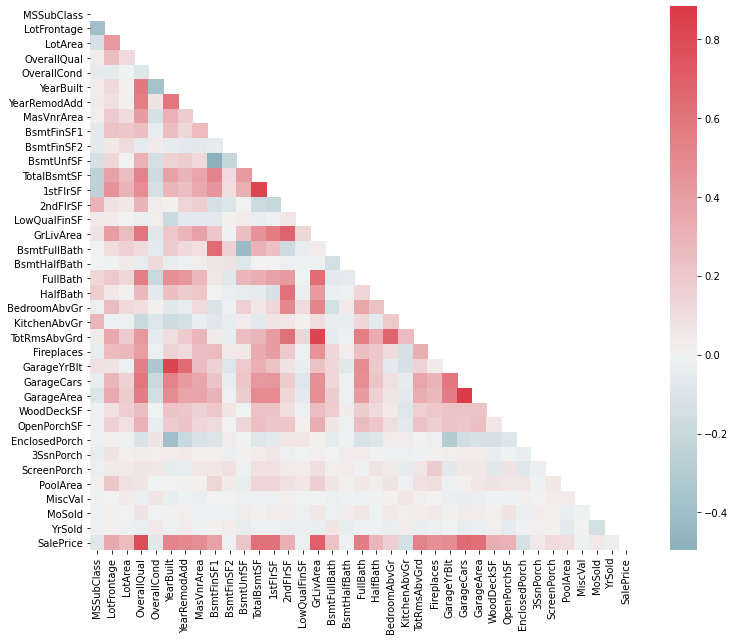

In [17]:
# correlation matrix
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corr, cmap=cmap, mask=mask, center=0.00, square=True) 

OverallQual and GrLivArea are highly correlated with SalePrice.
Possible evidence of multicollinearity: GarageYrBlt & YearBuilt, 1stFlrSF & TotalBsmtSF, TotRmsAbvGrd & GrLivArea, GarageArea & GarageCars.

<AxesSubplot:>

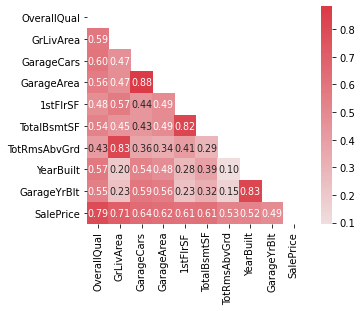

In [18]:
cols = ['OverallQual','GrLivArea','GarageCars','GarageArea','1stFlrSF','TotalBsmtSF','TotRmsAbvGrd','YearBuilt','GarageYrBlt','SalePrice']
mask = np.triu(np.ones_like(corr.loc[cols,cols], dtype=bool))
sns.heatmap(corr.loc[cols,cols], cmap=cmap, center=0.00, mask=mask, square=True, annot=True, fmt='.2f', annot_kws={'size':9.5})

We can consider keeping YearBuilt and dropping GarageYrBlt as the former is more correlated with SalePrice. Using the same logic, we might also consider dropping TotRmsAbvGrd and GarageArea. 1stFlrSF and TotalBsmtSF have the same correlation with SalePrice so we could consider combining them to create a new feature.

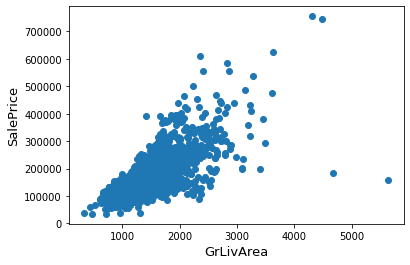

In [19]:
# plot SalePrice against GrLivArea            (maybe develop a better way of detecting outliers)
fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

There appear to be two outliers at the bottom right.

In [23]:
# concatenate train and test set
all_data = pd.concat([train_df.drop('SalePrice', axis=1), test_df], ignore_index=True)

In [24]:
# replace all NAs in features where NA is a category with 'None' (this assumes none of the NAs actually represent a missing value but we'll correct this next)
cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
all_data[cols] = all_data[cols].fillna('None')
# examine missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.loc[missing_data['Total'] > 0]

,Total,Percent
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrType,24,0.008222
MasVnrArea,23,0.007879
MSZoning,4,0.001370
BsmtHalfBath,2,0.000685
Functional,2,0.000685
BsmtFullBath,2,0.000685
Utilities,2,0.000685
Exterior2nd,1,0.000343


In [25]:
# check for contradictions in categorical Garage variables
rows = ((all_data['GarageType'] == 'None') | (all_data['GarageFinish'] == 'None') | (all_data['GarageQual'] == 'None') | (all_data['GarageCond'] == 'None')) \
    & ~((all_data['GarageType'] == all_data['GarageFinish']) & (all_data['GarageFinish'] == all_data['GarageQual']) & (all_data['GarageQual'] == all_data['GarageCond']))
all_data.loc[rows, 'GarageType':'GarageCond']

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
2126,Detchd,NaN,None,1.0,360.0,None,None
2576,Detchd,NaN,None,NaN,NaN,None,None


For the 1st entry, there are values for GarageType, GarageCars and GarageArea so we'll assume the other Garage variables with 'None' actually mean missing rather than 'No Garage'. We'll impute them with the mode. The 2nd entry happens to be responsible for the single missing entry in GarageArea and GarageCars. The GarageType is 'detached', but all other Garage variables imply the house has no garage. We'll assume the GarageType is erroneous and that there is no garage, imputing the missing values accordingly. We can now also set all missing values for GarageYrBlt to be 0 if there is no garage, and if there is a garage, we'll assume it's equal to the YearBuilt. 

In [26]:
# impute missing data for 1st entry
all_data.loc[2126,'GarageFinish'] = all_data['GaarageFinish'].value_counts().index[0]
all_data.loc[2126,'GarageQual'] = all_data['GarageQual'].value_counts().index[0]
all_data.loc[2126,'GarageCond'] = all_data['GarageCond'].value_counts().index[0]
# impute missing data for 2nd entry
all_data.loc[2576,'GarageType'] = 'None'
all_data.loc[2576,'GarageCars'] = 0
all_data.loc[2576,'GarageArea'] = 0
# impute missing values for GarageYrBlt
all_data.loc[all_data['GarageType'] == 'None', 'GarageYrBlt'] = 0
all_data.loc[all_data['GarageType'] != 'None', 'GarageYrBlt'] = all_data.loc[all_data['GarageType'] != 'None', 'YearBuilt']

KeyError: 'GaarageFinish'

In [27]:
# check for contradictions in categorical Bsmt variables
rows = ((all_data['BsmtQual'] == 'None') | (all_data['BsmtCond'] == 'None') | (all_data['BsmtExposure'] == 'None') | (all_data['BsmtFinType1'] == 'None') | (all_data['BsmtFinType2'] == 'None')) \
    & ~((all_data['BsmtQual'] == all_data['BsmtCond']) & (all_data['BsmtCond'] == all_data['BsmtExposure']) & (all_data['BsmtExposure'] == all_data['BsmtFinType1']) & (all_data['BsmtFinType1'] == all_data['BsmtFinType2']))
all_data.loc[rows, 'BsmtQual':'BsmtFinSF2']

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2
332,Gd,TA,No,GLQ,1124.0,None,479.0
948,Gd,TA,None,Unf,0.0,Unf,0.0
1487,Gd,TA,None,Unf,0.0,Unf,0.0
2040,Gd,None,Mn,GLQ,1044.0,Rec,382.0
2185,TA,None,No,BLQ,1033.0,Unf,0.0
2217,None,Fa,No,Unf,0.0,Unf,0.0
2218,None,TA,No,Unf,0.0,Unf,0.0
2348,Gd,TA,None,Unf,0.0,Unf,0.0
2524,TA,None,Av,ALQ,755.0,Unf,0.0


Clearly, all the 'None' values in each entry actually represent a missing value rather than 'No Basement' since all other Bsmt variables imply there is a basement. We'll impute the missing values with the mode. 

In [28]:
# impute missing values
all_data.loc[332,'BsmtFinType2'] = all_data['BsmtFinType2'].value_counts().index[0]
all_data.loc[[948,1487,2348],'BsmtExposure'] = all_data['BsmtExposure'].value_counts().index[0]
all_data.loc[[2040,2185,2524],'BsmtCond'] = all_data['BsmtCond'].value_counts().index[0]
all_data.loc[[2217,2218],'BsmtQual'] = all_data['BsmtQual'].value_counts().index[0]

In [29]:
# examine missing entries for BsmtHalfBath
all_data.loc[all_data[all_data['BsmtHalfBath'].isnull()].index.tolist(),['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','BsmtQual']]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual
2120,NaN,NaN,NaN,NaN,NaN,NaN,None
2188,0.0,0.0,0.0,0.0,NaN,NaN,None


These two houses are responsible for all the missing entries in the numeric Bsmt variables. Since both houses have no basement as BsmtQual = 'None', we can assume all the missing values are 0. 

In [30]:
# impute missing data
cols = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
all_data[cols] = all_data[cols].fillna(0)

In [31]:
# examine missing entries for MasVnrType
all_data.loc[all_data[all_data['MasVnrType'].isnull()].index.tolist(),'MasVnrType':'MasVnrArea']

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN
1691,NaN,NaN
1706,NaN,NaN


All houses with missing entries for MasVnrType also have missing entries for MasVnrArea and vice-versa, with one exception. If a house has a masonry veneer area, it must have a masonry veneer type, so for this particular entry, we'll set the type as the mode (excluding 'None'). We'll assume all the other missing entries have no masonry veneer and thus 0 MasVnrArea.

In [32]:
# impute missing data
all_data.loc[2610,'MasVnrType'] = all_data['MasVnrType'].value_counts().index[1]
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

In [33]:
# examine entries for MSZoning, Electrical, Functional and SaleType
print(all_data['MSZoning'].value_counts())
print('\n')
print(all_data['Electrical'].value_counts())
print('\n')
print(all_data['Functional'].value_counts())
print('\n')
print(all_data['SaleType'].value_counts())

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


All these variables have a category which occurs much more frequently than the others, so we'll replace the missing values with those. 

In [34]:
# impute missing data
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')

In [35]:
# examine entries for Utilities
print('Train set:')
print(train_df['Utilities'].value_counts())
print('Number of missing values:')
print(sum(train_df['Utilities'].isnull()))
print('\nTest set:')
print(test_df['Utilities'].value_counts())
print('Number of missing values:')
print(sum(test_df['Utilities'].isnull()))

Train set:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Number of missing values:
0

Test set:
AllPub    1457
Name: Utilities, dtype: int64
Number of missing values:
2


Utilities in the test set consists entirely of 'AllPub' and has 2 missing values. Imputing 'AllPub' for these missing values would mean all houses in the test set have 'AllPub' making the variable unnecessary for prediction, so we can drop it. 

In [36]:
# drop Utilities
all_data = all_data.drop(['Utilities'], axis=1)

We'll assume that houses in the same neighbourhood will have similar lot frontage and impute the missing LotFrontage values using the median LotFrontage of the neighbourhood. We could improve this by training a separate model on our data to predict the missing LotFrontage values

In [37]:
# impute missing data
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [38]:
# examine missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.loc[missing_data['Total'] > 0]

,Total,Percent
GarageYrBlt,159,0.054471
Exterior2nd,1,0.000343
KitchenQual,1,0.000343
GarageCars,1,0.000343
GarageArea,1,0.000343
Exterior1st,1,0.000343


The remaining variables which have missing values are all categorical and only have 1 NA so we'll just set those as the mode. 

In [39]:
# impute missing data
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].value_counts().index[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].value_counts().index[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].value_counts().index[0])

Looking at the data description, the numbers in MSSubClass don't seem to represent any sort of ordering so we'll treat it as categorical rather than numeric. 

In [40]:
# transform MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

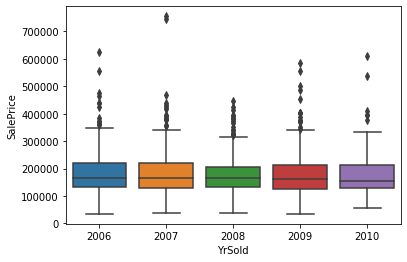

In [41]:
# plot SalePrice against YrSold
sns.boxplot(x='YrSold',y='SalePrice',data=train_df)

There doesn't really appear to be any trend so we'll treat YrSold as categorical rather than numeric. 

In [42]:
# transform YrSold
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [47]:
all_data['YrSold']).dtype()

TypeError: 'numpy.dtype' object is not callable

In [ ]:
# feature engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['GrLivArea']
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + 0.5 * (all_data['BsmtHalfBath'] + all_data['HalfBath'])
# transform the cyclical feature MoSold (http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)
# note: not sure if this method is appropriate for a random forest model since only one of the two transformed features will be present for each split decision. 
# but it improves the accuracy so...
all_data['SinMoSold'] = np.sin(2 * np.pi * all_data['MoSold'] / 12)
all_data['CosMoSold'] = np.cos(2 * np.pi * all_data['MoSold'] / 12)
all_data = all_data.drop('MoSold', axis=1)
# convert categorical variables to dummy variables
all_data = pd.get_dummies(all_data)

In [ ]:
# feature importance
ntrain = train_df.shape[0]
X = all_data[:ntrain]
y = train_df['SalePrice']
rf = RandomForestRegressor(random_state=42, n_estimators=360).fit(X, y)
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()
feature_importances.head(20)

In [ ]:
# drop 218 least important features (this number was found using a semi-exhaustive search, this whole feature selection process needs improving). 
cols = feature_importances.tail(218).index.values.tolist()
all_data = all_data.drop(cols, axis=1)

In [ ]:
# 5-fold cross-validation
X = all_data[:ntrain]
rf = RandomForestRegressor(random_state=42, n_estimators=360).fit(X, y)
scores = -1 * cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Average RMSE score (across experiments):")
print(scores.mean())
# 28698.17 dropping 218 features

In [ ]:
# create submission             
rf = RandomForestRegressor(random_state=42, n_estimators=360).fit(X, y)
test_df = all_data[ntrain:]
rf.fit(X,y)
submission = pd.DataFrame()
submission['Id'] = test_Id
submission['SalePrice'] = rf.predict(test_df)
submission.to_csv('submission.csv',index=False)